## Business Problem Statement
    - The client, wanted to integrate the chemical and supplier knowledge base of an acquired firm. This would help enlarge and strengthen the firm’s ability to create and market new flavors across the world.
    - The data was almost exclusively available in the form of ~1 million scanned PDF docs, making data extraction and integration extremely laborious & error prone thus resulting in inefficient usage of employee time.


### The solution consisted of essentially 3 parts:

    - The custom OCR solution extracted the raw text from images/PDFs using the Open Source Tesseract engine, with an average accuracy > 89%.
    - Custom built ML algorithms analyzed the extracted raw text to convert the OCR output (raw text) into a structured data format
    - spaCy custom entity recognition model – used to extract material specs as an entity
    -Custom decision tree algorithm – to match the mis-aligned specifications to correct spec/value combination by utilizing mapped ontologies between the key data fields & corresponding values
    -Custom ML algorithms to aide the client by comparing the structured data (obtained after the above 2 parts) with existing client data
    -Clustering (Kmean, LDA), W2V and KNN algorithms to assign a ‘similarity score’ to different data sets thereby drastically time required for data harmonization

### Key Benefits:
    - Creation of specialized, client context specific ontologies and chemical synonym dictionaries on cloud infrastructure allowing easy future deployment.
    - Saved more than 5,000 man days of work translating to a benefit of >$750k.


# spaCy custom entity recognition model – used to extract material specs as an entity

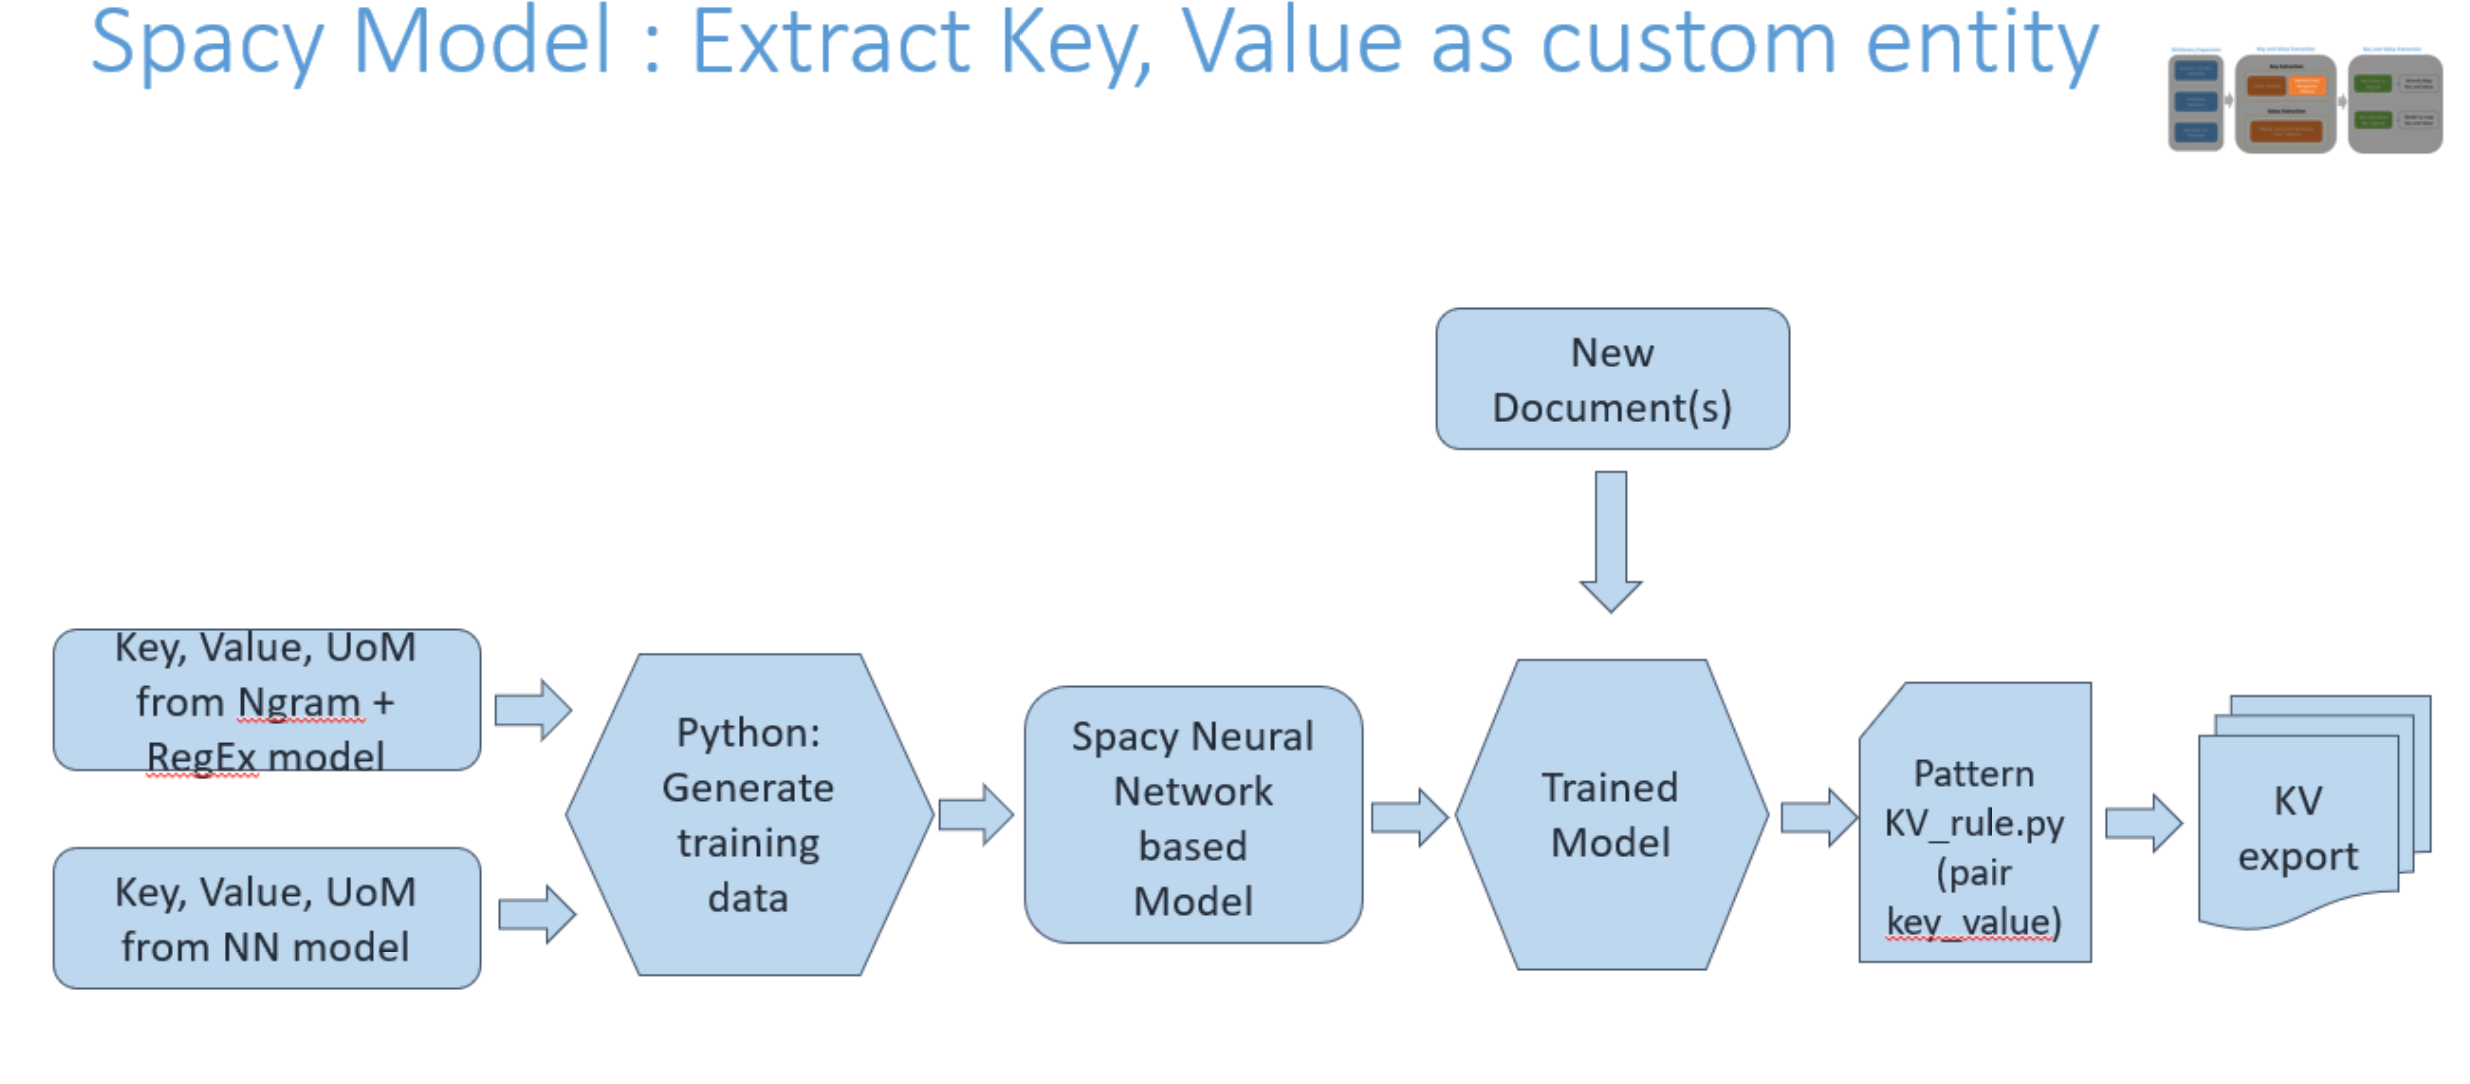

In [1]:
import spacy
from spacy.util import minibatch, compounding
import plac
from pathlib import Path
import random
import pandas as pd
import os

In [2]:
os.chdir("D:/IFF/trainingData")

In [3]:
nlp = spacy.blank("en") 

In [4]:
def getData(inputFilePath , n_head=350):
    kv_file_full=pd.read_csv(inputFilePath, sep='|')
    print("Comple file:" ,len(kv_file_full))
    training_data = []
    kv_file = kv_file_full.drop_duplicates(['Key','Value','text'])
    kv_file = kv_file[(kv_file.tag == 1)]
    kv_file["Key"] = kv_file["Key"].str.strip()
    kv_file["Value"] = kv_file["Value"].str.strip()
    kv_file = kv_file[(kv_file.Key != "") & (kv_file.Value != "")] 
    print("Filter Data:",len(kv_file))
    for index, row in kv_file.head(n_head).iterrows():    
        klist=[]
        vlist=[]
        text = str(row['text']).strip()
        key=str(row['Key']).strip()
        value=str(row['Value']).strip()

        if "," in key:        
            klist = key.split(",")
            vlist = value.split(",")
        else:           
            klist = [key] 
            vlist = [value]

        maxCount = len(vlist) if len(vlist) < len(klist) else len(klist) 

        entities = []
        for count in range(0, maxCount):
            key = klist[count]
            value = vlist[count]        
            keybig = text.find(key.lower().strip())
            keyend =keybig+len(key.strip())
            kvaluebig = text.find(str(value).lower().strip())
            kvalueend = kvaluebig + len(str(value).strip())                            

            if (keybig >=0 and kvaluebig >=0):
                if (keybig < kvaluebig):
                    entities.append((keybig, keyend ,"FKEY"));
                    entities.append((kvaluebig, kvalueend ,"FKVAL"));
                else:
                    entities.append((kvaluebig, kvalueend ,"FKVAL"));
                    entities.append((keybig, keyend ,"FKEY")); 
        if(len(entities) >0 ) :           
            training_data.append((row['text'], {"entities" : entities}))

    return training_data

## Get the data and split into test and train data

In [6]:
# Get the data and split into test and train data
DATA = getData("D:/IFF/trainingData/SPEC/filterSpectFile.csv", 600)
print(len(DATA))
TR_DATA = DATA[0:350]  # Training Data
TE_DATA = DATA[350:500]  # Test data

Comple file: 1483
Filter Data: 816
514


## Create ner pipline

In [7]:
nlp = spacy.blank("en") 
if "ner" not in nlp.pipe_names:
    print("1")
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
else:
    print("2")
    ner = nlp.get_pipe("ner")
    
for _, annotations in TR_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
        
print("Step 1 Completed")        

1
Step 1 Completed


# Train the model

In [8]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
other_pipes

n_iter=100
with nlp.disable_pipes(*other_pipes):  # only train NER
        # reset and initialize the weights randomly – but only if we're
        # training a new model
        #print("1*****")
        #if model is None: NS Comment
        nlp.begin_training()
        #print("3*****")
        for itn in range(n_iter):
            random.shuffle(TR_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            #print("4*****")
            batches = minibatch(TR_DATA, size=compounding(4.0, 32.0, 1.001))
            #print("batches:",batches)
            print(type(batches))
            for batch in batches:
                #print("41*****")
                texts, annotations = zip(*batch)
                #print(texts)
                #print("##########")
                #print(annotations)
                #print("*****")
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            #print("Losses", losses)

print("Step 2 Completed")        

<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>
<class 'generator'>


## Save Model

In [9]:

output_dir="D:/IFF/trainingData/outDir/"
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)

print("Step 3 Completed")          

Saved model to D:\IFF\trainingData\outDir
Step 3 Completed


## Load and test the saved model

In [10]:
from spacy.gold import GoldParse
from spacy.scorer import Scorer
    
output_dir="D:/IFF/trainingData/outDir/"

res = []
dfOut = pd.DataFrame(columns=["text","key","val"])
dfOutScore = pd.DataFrame(columns=["text","key","val"])

if output_dir is not None:
    print("Loading from", output_dir)
    nlp2 = spacy.load(output_dir)
    scorer = Scorer()
    for input_, annot in TE_DATA[0:200]:    
        e = annot.get("entities")
        doc_gold_text = nlp2.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot['entities'])
        pred_value = nlp2(input_)
        #print("Text:",pred_value)
        #print("Entities:", [(ent.text, ent.label_) for ent in pred_value.ents])     
                
        key=""
        value=""
        for ent in pred_value.ents:
            if (ent.label_ == "FKEY"):
                
                key=ent.text if key == "" else key + "," + ent.text
               #print("This is FKEY")
                #print(ent.text, ent.label_)
            elif (ent.label_ == "FKVAL"):
                value=ent.text if value =="" else value + "," + ent.text
                #print("This is value")
                #print(ent.text, ent.label_)
        #print("---------------------------------")
        dfOutScore = dfOutScore.append({"text": input_,"key":key,"val":value},ignore_index = True )

        ######
       
       #print("gold",gold)
        scorer.score(pred_value, gold)
        
print(scorer.scores    )
print("Step4 Completed")        

Loading from D:/IFF/trainingData/outDir/
{'uas': 0.0, 'las': 0.0, 'ents_p': 77.96052631578947, 'ents_r': 78.47682119205298, 'ents_f': 78.21782178217823, 'tags_acc': 0.0, 'token_acc': 100.0}
Step4 Completed


## Process Complete:

In [11]:
dfOutScore.to_csv("outScore.csv", sep="|")